### Vehicle Routing Problem using QAOA

In [1]:
# importing required libraries
import numpy as np
import matplotlib.pyplot as plt
import sys
import operator

In [2]:
#importing qiskit packages
from qiskit import BasicAer
from qiskit.quantum_info import Pauli
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import QAOA
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer

In [3]:
#Setting values for given problem
n = 4# Total number of nodes(In the problem, (number of delivery centres + 1 depot))
veh = 2 # Total number of vehicles

In [4]:
# randomnly placing nodes and computing distances between nodes

np.random.seed(1543) 
x = (np.random.rand(n)-0.5)*10
y = (np.random.rand(n)-0.5)*10

matrix = np.zeros([n,n]) 
    
# creating the distance matrix to indicate distances between individual nodes
for i in range(n):
    for j in range(i+1,n):
        matrix[i,j] = (x[i]-x[j])**2 + (y[i]-y[j])**2
        matrix[j,i] = matrix[i,j]
# print(matrix)
# print(x,y)

In [5]:
# encoding the problem into a QuadraticProgram instance
def instance(n,veh,matrix,x_sol=0):
    #parameter for cost function
    A = np.max(matrix) * 100 

    #defining weights w
    matrix_vec = matrix.reshape(n ** 2)
    w_list = [matrix_vec[x] for x in range(n ** 2) if matrix_vec[x] > 0]
    w = np.zeros(n * (n - 1))
    for i in range(len(w_list)):
        w[i] = w_list[i]
    
    # print(matrix_vec)
    # print(w)

    #Finding the value of Q (Q defines the interactions between variables)
    e1_id = np.eye(n)
    e1_1 = np.ones([n-1,n-1])
    e2 = np.ones(n)
    e2_1 = np.ones(n-1)
    e2[0]=0
    neg_e2 = np.ones(n) - e2

    v = np.zeros([n,n*(n-1)])
    for i in range(n):
            count = i - 1
            for j in range(n * (n - 1)):

                if j // (n - 1) == i:
                    count = i

                if j // (n - 1) != i and j % (n - 1) == count:
                    v[i][j] = 1.0

    # print(neg_e2)                    
    #print(v)
    v1 = np.sum(v[1:], axis=0)
    #print(v1)
    Q = A*(np.kron(e1_id,e1_1)) + np.dot(v.T,v)

    #Finding the value of g
    g = (w
    - 2*A*(np.kron(e2,e2_1) + v1.T)
    - 2*A*veh*(np.kron(neg_e2,e2_1) + v[0].T)
    )

    #Finding the value of c
    c = 2 * A * (n-1) + 2 * A * (veh**2)

    try:
        #max(x_sol)
        # Evaluates the cost distance from a binary representation of a path
        fun = (
            lambda x: np.dot(np.around(x), np.dot(Q, np.around(x)))
            + np.dot(g, np.around(x))
            + c
            )
        cost = fun(x_sol)
    except:
        cost = 0
        
    return Q,g,c,cost

In [6]:
#creating the QuadraticProgram instance using the above calculated values
def q_program(n,veh,matrix,Q,g,c):
    qp = QuadraticProgram()
    for i in range(n*(n-1)):
        qp.binary_var(str(i))
    qp.objective.quadratic = Q
    qp.objective.linear = g
    qp.objective.constant = c
    return qp

In [7]:
#solving the problem using qiskit optimization techniques
def solution(n,veh,matrix,qp):
    algorithm_globals.random_seed = 10598
    backend = BasicAer.get_backend('qasm_simulator')
    quantum_instance = QuantumInstance(backend,
                    seed_simulator = algorithm_globals.random_seed,
                    seed_transpiler = algorithm_globals.random_seed
                     )

    qaoa = QAOA(quantum_instance=quantum_instance)
    optimizer = MinimumEigenOptimizer(min_eigen_solver=qaoa)
    result = optimizer.solve(qp)
    _,_,_,cost = instance(n,veh,matrix,x_sol=result.x)
    print(result)
    print(result.x)
    return result.x, cost

In [8]:
Q,g,c,cost=instance(n,veh,matrix)
qp = q_program(n,veh,matrix,Q,g,c)
quantum_solution, quantum_cost = solution(n,veh,matrix,qp)
# print(qp)
# print(quantum_cost)
# print(cost)

optimal function value: -81915.28116537273
optimal value: [1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1.]
status: SUCCESS
[1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1.]


In [9]:
print(quantum_solution, quantum_cost)

[1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1.] -81915.28116537273


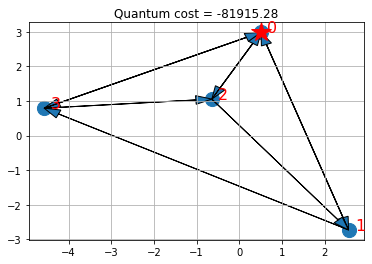

In [10]:
x_quantum = np.zeros(n**2)
k = 0
for i in range(n ** 2):
    if i // n != i % n:
        x_quantum[i] = quantum_solution[k]
        k +=  1
# Visualize the solution
def visualize_solution(x, y, x_q, C, n, K, title_str):
    plt.figure()
    plt.scatter(x, y, s=200)
    for i in range(len(x)):
        plt.annotate(i, (x[i] + 0.15, y[i]), size=16, color='r')
    plt.plot(x[0], y[0], 'r*', ms=20)

    plt.grid()

    for ii in range(0, n ** 2):

        if x_q[ii] > 0:
            ix = ii // n
            iy = ii % n
            plt.arrow(x[ix], y[ix], x[iy] - x[ix], y[iy] - y[ix], length_includes_head=True, head_width=.25)

    plt.title(title_str+' cost = ' + str(int(C * 100) / 100.))
    plt.show()
visualize_solution(x, y, x_quantum, quantum_cost, n, veh, 'Quantum')